In [1]:
# ============================================================================
# BLOCK 1: INITIAL SETUP AND DATA EXTRACTION
# ============================================================================

from google.colab import drive
import zipfile, os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset zip in Drive
zip_path = "/content/drive/MyDrive/Hackathon/pre_processed_brain-tumor-dataset.zip"
extract_path = "/content/brain_tumor_dataset"

# Extract only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(" Dataset extracted to:", extract_path)

!ls -R /content/brain_tumor_dataset | head -50


Mounted at /content/drive
 Dataset extracted to: /content/brain_tumor_dataset
/content/brain_tumor_dataset:
pre_processed_brain-tumor-dataset

/content/brain_tumor_dataset/pre_processed_brain-tumor-dataset:
Testing
Training
Validation

/content/brain_tumor_dataset/pre_processed_brain-tumor-dataset/Testing:
glioma
meningioma
notumor
pituitary

/content/brain_tumor_dataset/pre_processed_brain-tumor-dataset/Testing/glioma:
Te-gl_0131.jpg
Te-gl_0132.jpg
Te-gl_0133.jpg
Te-gl_0134.jpg
Te-gl_0135.jpg
Te-gl_0136.jpg
Te-gl_0137.jpg
Te-gl_0138.jpg
Te-gl_0139.jpg
Te-gl_0140.jpg
Te-gl_0141.jpg
Te-gl_0142.jpg
Te-gl_0143.jpg
Te-gl_0144.jpg
Te-gl_0145.jpg
Te-gl_0146.jpg
Te-gl_0147.jpg
Te-gl_0148.jpg
Te-gl_0149.jpg
Te-gl_0150.jpg
Te-gl_0151.jpg
Te-gl_0152.jpg
Te-gl_0153.jpg
Te-gl_0154.jpg
Te-gl_0155.jpg
Te-gl_0156.jpg
Te-gl_0157.jpg
Te-gl_0158.jpg
Te-gl_0159.jpg
Te-gl_0160.jpg
Te-gl_0161.jpg
Te-gl_0162.jpg
Te-gl_0163.jpg
Te-gl_0164.jpg
Te-gl_0165.jpg


In [2]:
# ============================================================================
# BLOCK 2: IMAGE PREPROCESSING AND SHARPENING
# ============================================================================

import cv2
import shutil
import numpy as np
from tqdm import tqdm

input_base = "/content/brain_tumor_dataset/pre_processed_brain-tumor-dataset"
output_base = "/content/brain_tumor_dataset_sharpened"

# Reset sharpened dataset folder
if os.path.exists(output_base):
    shutil.rmtree(output_base)
os.makedirs(output_base, exist_ok=True)

# Sharpening kernel
sharpen_kernel = np.array([[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]])

# Apply sharpening to all images
for split in ['Training', 'Validation', 'Testing']:
    split_input = os.path.join(input_base, split)
    split_output = os.path.join(output_base, split)
    os.makedirs(split_output, exist_ok=True)

    for cls in tqdm(os.listdir(split_input), desc=f"Processing {split}"):
        class_input = os.path.join(split_input, cls)
        class_output = os.path.join(split_output, cls)
        os.makedirs(class_output, exist_ok=True)

        for img_name in os.listdir(class_input):
            img_path = os.path.join(class_input, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            sharpened = cv2.filter2D(img, -1, sharpen_kernel)
            cv2.imwrite(os.path.join(class_output, img_name), sharpened)

print(" Sharpened dataset saved at:", output_base)


Processing Testing: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

 Sharpened dataset saved at: /content/brain_tumor_dataset_sharpened


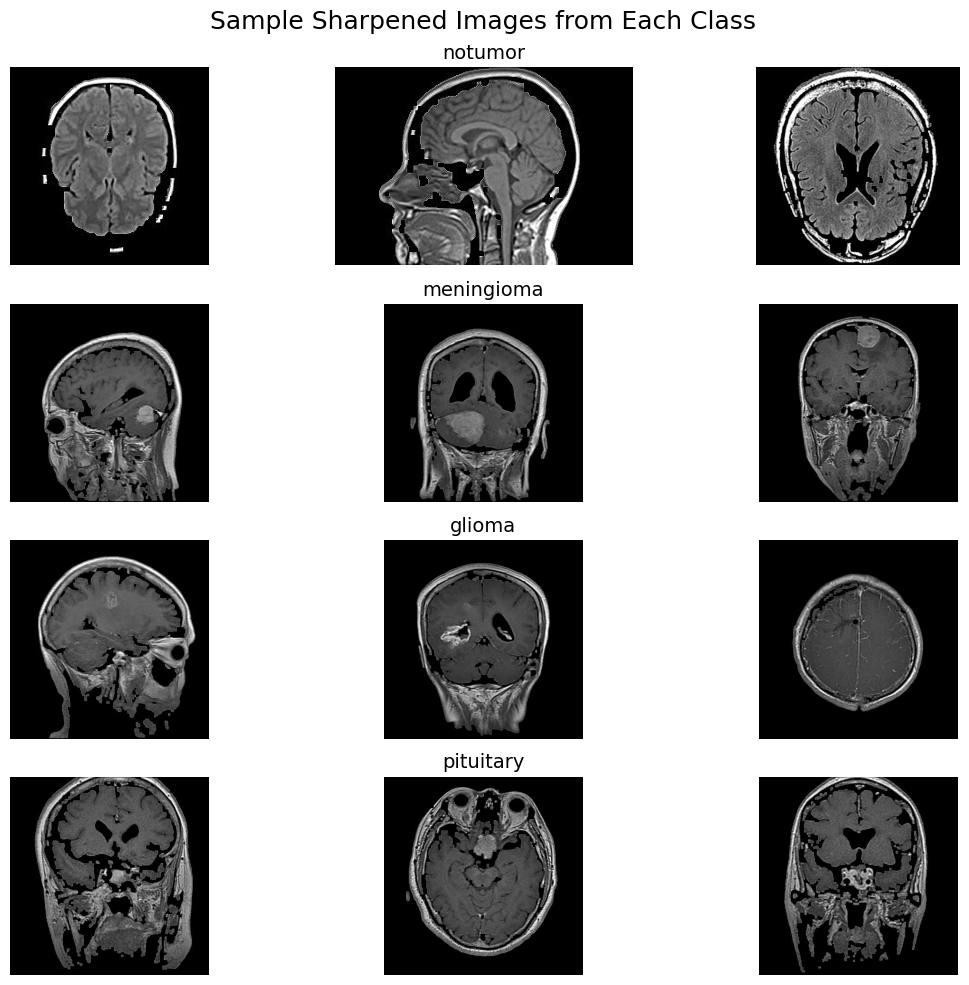

In [3]:
# ============================================================================
# BLOCK 3: DATA VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt

# Display sample images from each class
train_path = os.path.join(output_base, "Training")
classes = os.listdir(train_path)
n_samples = 3

plt.figure(figsize=(12, 10))
for i, cls in enumerate(classes):
    folder = os.path.join(train_path, cls)
    images = os.listdir(folder)[:n_samples]

    for j, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), n_samples, i*n_samples + j + 1)
        plt.imshow(img)
        plt.axis("off")
        if j == 1:
            plt.title(cls, fontsize=14)

plt.suptitle("Sample Sharpened Images from Each Class", fontsize=18)
plt.tight_layout()
plt.show()


In [4]:
# ============================================================================
# BLOCK 4: DATA GENERATORS SETUP
# ============================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration
IMG_SIZE = (224, 224)  # InceptionV3 input size
BATCH_SIZE = 32

# Data generators with augmentations for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Simple rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define paths
train_dir = os.path.join(output_base, "Training")
val_dir = os.path.join(output_base, "Validation")
test_dir = os.path.join(output_base, "Testing")

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(" Data Generators ready")
print("Classes:", train_gen.class_indices)


Found 5712 images belonging to 4 classes.
Found 1055 images belonging to 4 classes.
Found 256 images belonging to 4 classes.
 Data Generators ready
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [5]:
# ============================================================================
# BLOCK 5: MODEL BUILDING
# ============================================================================

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained InceptionV3 model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [6]:
# ============================================================================
# BLOCK 6: TRAINING SETUP AND CALLBACKS
# ============================================================================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Setup callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        'inceptionv3_brain_tumor.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Initial training phase
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.5396 - loss: 1.1041
Epoch 1: val_loss improved from inf to 0.62000, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 675ms/step - accuracy: 0.5402 - loss: 1.1027 - val_accuracy: 0.7621 - val_loss: 0.6200 - learning_rate: 1.0000e-04
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7582 - loss: 0.6244
Epoch 2: val_loss improved from 0.62000 to 0.50676, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 518ms/step - accuracy: 0.7583 - loss: 0.6242 - val_accuracy: 0.8028 - val_loss: 0.5068 - learning_rate: 1.0000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8031 - loss: 0.5348
Epoch 3: val_loss improved from 0.50676 to 0.50435, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 520ms/step - accuracy: 0.8031 - loss: 0.5347 - val_accuracy: 0.7972 - val_loss: 0.5044 - learning_rate: 1.0000e-04
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8197 - loss: 0.4966
Epoch 4: val_loss improved from 0.50435 to 0.46226, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 496ms/step - accuracy: 0.8197 - loss: 0.4966 - val_accuracy: 0.8171 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8293 - loss: 0.4548
Epoch 5: val_loss did not improve from 0.46226
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 485ms/step - accuracy: 0.8293 - loss: 0.4548 - val_accuracy: 0.8161 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8356 - loss: 0.4335
Epoch 6: val_loss improved from 0.46226 to 0.43720, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 500ms/step - accuracy: 0.8356 - loss: 0.4335 - val_accuracy: 0.8360 - val_loss: 0.4372 - learning_rate: 1.0000e-04
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8405 - loss: 0.4208
Epoch 7: val_loss did not improve from 0.43720
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 502ms/step - accuracy: 0.8405 - loss: 0.4208 - val_accuracy: 0.8227 - val_loss: 0.4679 - learning_rate: 1.0000e-04
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8344 - loss: 0.4238
Epoch 8: val_loss improved from 0.43720 to 0.42992, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 487ms/step - accuracy: 0.8344 - loss: 0.4237 - val_accuracy: 0.8370 - val_loss: 0.4299 - learning_rate: 1.0000e-04
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8450 - loss: 0.4027
Epoch 9: val_loss improved from 0.42992 to 0.41735, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 500ms/step - accuracy: 0.8450 - loss: 0.4026 - val_accuracy: 0.8408 - val_loss: 0.4173 - learning_rate: 1.0000e-04
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8520 - loss: 0.3803
Epoch 10: val_loss improved from 0.41735 to 0.40740, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 483ms/step - accuracy: 0.8521 - loss: 0.3803 - val_accuracy: 0.8389 - val_loss: 0.4074 - learning_rate: 1.0000e-04
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8502 - loss: 0.3916
Epoch 11: val_loss improved from 0.40740 to 0.39045, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 491ms/step - accuracy: 0.8503 - loss: 0.3916 - val_accuracy: 0.8512 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8538 - loss: 0.3769
Epoch 12: val_loss improved from 0.39045 to 0.37744, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.8538 - loss: 0.3769 - val_accuracy: 0.8474 - val_loss: 0.3774 - learning_rate: 1.0000e-04
Epoch 13/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8735 - loss: 0.3516
Epoch 13: val_loss did not improve from 0.37744
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 494ms/step - accuracy: 0.8735 - loss: 0.3516 - val_accuracy: 0.8531 - val_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 14/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8657 - loss: 0.3584
Epoch 14: val_loss improved from 0.37744 to 0.37094, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 512ms/step - accuracy: 0.8657 - loss: 0.3584 - val_accuracy: 0.8464 - val_loss: 0.3709 - learning_rate: 1.0000e-04
Epoch 15/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8721 - loss: 0.3385
Epoch 15: val_loss improved from 0.37094 to 0.36009, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 490ms/step - accuracy: 0.8721 - loss: 0.3385 - val_accuracy: 0.8569 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 16/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8755 - loss: 0.3378
Epoch 16: val_loss did not improve from 0.36009
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 485ms/step - accuracy: 0.8755 - loss: 0.3378 - val_accuracy: 0.8502 - val_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 17/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8647 - loss: 0.3444
Epoch 17: val_loss did not improve from 0.36009
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 503ms/step - accuracy: 0.8647 - loss: 0.3444 - val_accuracy: 0.8616 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 18/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8799 - loss: 0.3372
Epoch 18: val_loss improved from 0.36009 to 0.35809, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.8799 - loss: 0.3372 - val_accuracy: 0.8616 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 19/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8764 - loss: 0.3255
Epoch 19: val_loss did not improve from 0.35809
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 491ms/step - accuracy: 0.8764 - loss: 0.3255 - val_accuracy: 0.8502 - val_loss: 0.3803 - learning_rate: 1.0000e-04
Epoch 20/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8814 - loss: 0.3222
Epoch 20: val_loss improved from 0.35809 to 0.33901, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 492ms/step - accuracy: 0.8814 - loss: 0.3222 - val_accuracy: 0.8645 - val_loss: 0.3390 - learning_rate: 1.0000e-04
Epoch 21/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8811 - loss: 0.3057
Epoch 21: val_loss did not improve from 0.33901
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.8811 - loss: 0.3057 - val_accuracy: 0.8607 - val_loss: 0.3455 - learning_rate: 1.0000e-04
Epoch 22/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8802 - loss: 0.3143
Epoch 22: val_loss did not improve from 0.33901
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - accuracy: 0.8802 - loss: 0.3143 - val_accuracy: 0.8597 - val_loss: 0.3422 - learning_rate: 1.0000e-04
Epoch 23/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8889 - loss: 0.3078
Epoch 23: val_loss improved from 0.33901 to 0.32446, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 475ms/step - accuracy: 0.8889 - loss: 0.3077 - val_accuracy: 0.8692 - val_loss: 0.3245 - learning_rate: 1.0000e-04
Epoch 24/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8863 - loss: 0.2925
Epoch 24: val_loss did not improve from 0.32446
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.8863 - loss: 0.2925 - val_accuracy: 0.8493 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 25/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8866 - loss: 0.3025
Epoch 25: val_loss did not improve from 0.32446
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.8866 - loss: 0.3026 - val_accuracy: 0.8682 - val_loss: 0.3346 - learning_rate: 1.0000e-04
Epoch 26/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8903 - loss: 0.2865
Epoch 26: val_loss improved from 0.32446 to 0.31722, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 474ms/step - accuracy: 0.8903 - loss: 0.2865 - val_accuracy: 0.8739 - val_loss: 0.3172 - learning_rate: 1.0000e-04
Epoch 27/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8843 - loss: 0.3021
Epoch 27: val_loss improved from 0.31722 to 0.30779, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 481ms/step - accuracy: 0.8843 - loss: 0.3020 - val_accuracy: 0.8796 - val_loss: 0.3078 - learning_rate: 1.0000e-04
Epoch 28/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8992 - loss: 0.2861
Epoch 28: val_loss did not improve from 0.30779
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 483ms/step - accuracy: 0.8992 - loss: 0.2861 - val_accuracy: 0.8758 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 29/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8856 - loss: 0.2973
Epoch 29: val_loss did not improve from 0.30779
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 476ms/step - accuracy: 0.8856 - loss: 0.2972 - val_accuracy: 0.8711 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 30/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8927 - loss: 0.2791
Epoch 30: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 30: val_loss did not improve from 0.30779
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 483ms/step - accuracy: 0.8927 - 

179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.8960 - loss: 0.2767 - val_accuracy: 0.8768 - val_loss: 0.3060 - learning_rate: 3.0000e-05
Epoch 32/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9130 - loss: 0.2434
Epoch 32: val_loss did not improve from 0.30599
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - accuracy: 0.9130 - loss: 0.2434 - val_accuracy: 0.8758 - val_loss: 0.3147 - learning_rate: 3.0000e-05
Epoch 33/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.8981 - loss: 0.2672
Epoch 33: val_loss improved from 0.30599 to 0.30222, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 505ms/step - accuracy: 0.8981 - loss: 0.2672 - val_accuracy: 0.8872 - val_loss: 0.3022 - learning_rate: 3.0000e-05
Epoch 34/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9108 - loss: 0.2618
Epoch 34: val_loss improved from 0.30222 to 0.29656, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 491ms/step - accuracy: 0.9108 - loss: 0.2618 - val_accuracy: 0.8853 - val_loss: 0.2966 - learning_rate: 3.0000e-05
Epoch 35/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9070 - loss: 0.2556
Epoch 35: val_loss did not improve from 0.29656
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 500ms/step - accuracy: 0.9070 - loss: 0.2556 - val_accuracy: 0.8758 - val_loss: 0.3002 - learning_rate: 3.0000e-05
Epoch 36/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8997 - loss: 0.2709
Epoch 36: val_loss did not improve from 0.29656
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 487ms/step - accuracy: 0.8997 - loss: 0.2708 - val_accuracy: 0.8806 - val_loss: 0.3023 - learning_rate: 3.0000e-05
Epoch 37/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8981 - loss: 0.2559
Epoch 37: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 37: val_loss improved from 0.29656 to 0.29652, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.8981 - loss: 0.2559 - val_accuracy: 0.8815 - val_loss: 0.2965 - learning_rate: 3.0000e-05
Epoch 38/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9041 - loss: 0.2687
Epoch 38: val_loss improved from 0.29652 to 0.28962, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 498ms/step - accuracy: 0.9041 - loss: 0.2686 - val_accuracy: 0.8815 - val_loss: 0.2896 - learning_rate: 9.0000e-06
Epoch 39/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9007 - loss: 0.2667
Epoch 39: val_loss improved from 0.28962 to 0.28807, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 489ms/step - accuracy: 0.9007 - loss: 0.2667 - val_accuracy: 0.8815 - val_loss: 0.2881 - learning_rate: 9.0000e-06
Epoch 40/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9080 - loss: 0.2519
Epoch 40: val_loss did not improve from 0.28807
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 477ms/step - accuracy: 0.9080 - loss: 0.2518 - val_accuracy: 0.8806 - val_loss: 0.2902 - learning_rate: 9.0000e-06
Epoch 41/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9128 - loss: 0.2447
Epoch 41: val_loss improved from 0.28807 to 0.28804, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 495ms/step - accuracy: 0.9128 - loss: 0.2447 - val_accuracy: 0.8891 - val_loss: 0.2880 - learning_rate: 9.0000e-06
Epoch 42/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8995 - loss: 0.2563
Epoch 42: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.

Epoch 42: val_loss did not improve from 0.28804
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 471ms/step - accuracy: 0.8996 - loss: 0.2563 - val_accuracy: 0.8863 - val_loss: 0.2888 - learning_rate: 9.0000e-06
Epoch 43/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9012 - loss: 0.2599
Epoch 43: val_loss did not improve from 0.28804
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.9012 - loss: 0.2598 - val_accuracy: 0.8863 - val_loss: 0.2894 - learning_rate: 2.7000e-06
Epoch 44/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9177 - loss: 0.2294
Epoch 44: val_loss did not improve from 0.28804
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.9176 - l

In [7]:
# ============================================================================
# BLOCK 7: FINE-TUNING PHASE
# ============================================================================

# Unfreeze last layers for fine-tuning
fine_tune_at = 249
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune training
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

# Save model to Drive
!cp inceptionv3_brain_tumor.h5 /content/drive/MyDrive/


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7719 - loss: 0.5697
Epoch 1: val_loss did not improve from 0.28804
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 610ms/step - accuracy: 0.7722 - loss: 0.5691 - val_accuracy: 0.8777 - val_loss: 0.3173 - learning_rate: 1.0000e-05
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8815 - loss: 0.3227
Epoch 2: val_loss did not improve from 0.28804
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 489ms/step - accuracy: 0.8814 - loss: 0.3227 - val_accuracy: 0.8834 - val_loss: 0.3061 - learning_rate: 1.0000e-05
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9064 - loss: 0.2703
Epoch 3: val_loss improved from 0.28804 to 0.26743, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 497ms/step - accuracy: 0.9064 - loss: 0.2704 - val_accuracy: 0.8995 - val_loss: 0.2674 - learning_rate: 1.0000e-05
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9051 - loss: 0.2699
Epoch 4: val_loss improved from 0.26743 to 0.24990, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 492ms/step - accuracy: 0.9051 - loss: 0.2699 - val_accuracy: 0.9043 - val_loss: 0.2499 - learning_rate: 1.0000e-05
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9182 - loss: 0.2221
Epoch 5: val_loss improved from 0.24990 to 0.23678, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.9182 - loss: 0.2221 - val_accuracy: 0.9100 - val_loss: 0.2368 - learning_rate: 1.0000e-05
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9197 - loss: 0.2144
Epoch 6: val_loss improved from 0.23678 to 0.21354, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 472ms/step - accuracy: 0.9197 - loss: 0.2144 - val_accuracy: 0.9147 - val_loss: 0.2135 - learning_rate: 1.0000e-05
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9233 - loss: 0.2013
Epoch 7: val_loss improved from 0.21354 to 0.19554, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 487ms/step - accuracy: 0.9234 - loss: 0.2013 - val_accuracy: 0.9213 - val_loss: 0.1955 - learning_rate: 1.0000e-05
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9338 - loss: 0.1798
Epoch 8: val_loss improved from 0.19554 to 0.18220, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 474ms/step - accuracy: 0.9338 - loss: 0.1798 - val_accuracy: 0.9280 - val_loss: 0.1822 - learning_rate: 1.0000e-05
Epoch 9/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9372 - loss: 0.1851
Epoch 9: val_loss improved from 0.18220 to 0.17676, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 486ms/step - accuracy: 0.9372 - loss: 0.1851 - val_accuracy: 0.9261 - val_loss: 0.1768 - learning_rate: 1.0000e-05
Epoch 10/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9356 - loss: 0.1701
Epoch 10: val_loss improved from 0.17676 to 0.16766, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 498ms/step - accuracy: 0.9355 - loss: 0.1702 - val_accuracy: 0.9280 - val_loss: 0.1677 - learning_rate: 1.0000e-05
Epoch 11/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9383 - loss: 0.1667
Epoch 11: val_loss improved from 0.16766 to 0.15437, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 478ms/step - accuracy: 0.9383 - loss: 0.1666 - val_accuracy: 0.9384 - val_loss: 0.1544 - learning_rate: 1.0000e-05
Epoch 12/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9455 - loss: 0.1503
Epoch 12: val_loss did not improve from 0.15437
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.9455 - loss: 0.1503 - val_accuracy: 0.9384 - val_loss: 0.1555 - learning_rate: 1.0000e-05
Epoch 13/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9529 - loss: 0.1294
Epoch 13: val_loss improved from 0.15437 to 0.14736, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 489ms/step - accuracy: 0.9529 - loss: 0.1294 - val_accuracy: 0.9384 - val_loss: 0.1474 - learning_rate: 1.0000e-05
Epoch 14/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9515 - loss: 0.1346
Epoch 14: val_loss improved from 0.14736 to 0.13708, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - accuracy: 0.9515 - loss: 0.1346 - val_accuracy: 0.9422 - val_loss: 0.1371 - learning_rate: 1.0000e-05
Epoch 15/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9594 - loss: 0.1223
Epoch 15: val_loss improved from 0.13708 to 0.13064, saving model to inceptionv3_brain_tumor.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.9594 - loss: 0.1223 - val_accuracy: 0.9488 - val_loss: 0.1306 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95        50
  meningioma       0.95      0.95      0.95        56
     notumor       0.99      1.00      1.00       100
   pituitary       1.00      1.00      1.00        50

    accuracy                           0.98       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.98      0.98      0.98       256


Overall Test Accuracy: 97.66%


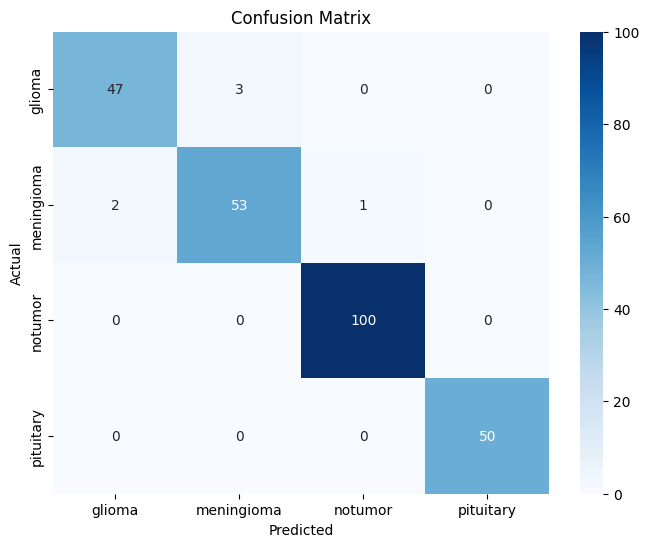

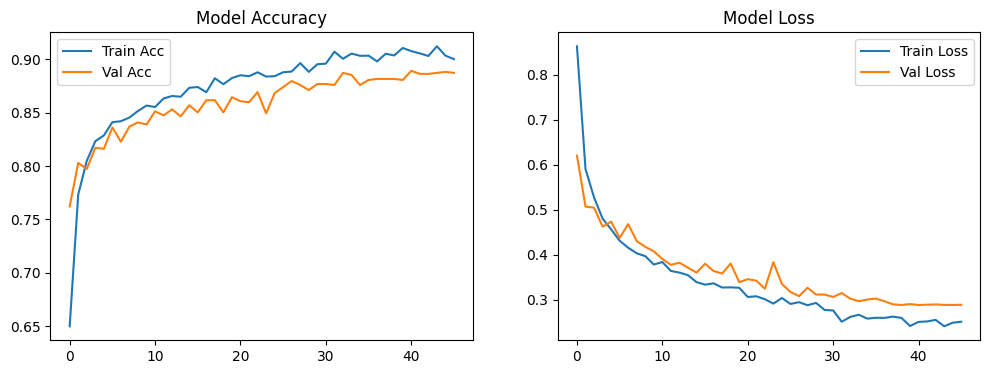

 Training and evaluation completed!


In [8]:
# ============================================================================
# BLOCK 8: MODEL EVALUATION AND RESULTS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

# Load best model and make predictions
model = load_model('inceptionv3_brain_tumor.h5')
Y_prob = model.predict(test_gen)
y_pred = np.argmax(Y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Print classification report
print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Test Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

print(" Training and evaluation completed!")


In [10]:
# ============================================================================
# COMPLETE BRAIN TUMOR TESTING CODE - FIXED VERSION WITH ALL IMPORTS
# ============================================================================

# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import io
from PIL import Image

print(" All libraries imported successfully!")

# ============================================================================
# METHOD 1: UPLOAD AND PREDICT (RECOMMENDED)
# ============================================================================

def upload_and_predict_colab():
    """Upload image using Google Colab interface and predict"""

    # Load the trained model
    print(" Loading trained InceptionV3 brain tumor model...")
    model = load_model('/content/drive/MyDrive/inceptionv3_brain_tumor.h5')

    # Define class names (adjust based on your dataset)
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

    # Upload image
    print(" Please upload an MRI brain scan image...")
    uploaded = files.upload()

    # Process uploaded image
    for filename in uploaded.keys():
        print(f"🔍 Processing image: {filename}")

        # Load and preprocess image
        image_bytes = uploaded[filename]
        image = Image.open(io.BytesIO(image_bytes))

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize to InceptionV3 input size (224x224)
        image_resized = image.resize((224, 224))

        # Convert to numpy array and normalize
        img_array = img_to_array(image_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        print(" Analyzing brain scan...")
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx] * 100

        # Display results
        plt.figure(figsize=(12, 6))

        # Show original image
        plt.subplot(1, 2, 1)
        plt.imshow(image_resized)
        plt.title(f"Input Image: {filename}", fontsize=14)
        plt.axis('off')

        # Show prediction probabilities
        plt.subplot(1, 2, 2)
        colors = ['red' if i == predicted_class_idx else 'lightblue' for i in range(len(class_names))]
        plt.bar(class_names, predictions[0] * 100, color=colors)
        plt.title('Prediction Probabilities (%)', fontsize=14)
        plt.ylabel('Confidence (%)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Print results
        print("\n" + "="*50)
        print(" BRAIN TUMOR CLASSIFICATION RESULTS")
        print("="*50)
        print(f" Image: {filename}")
        print(f" Predicted Class: {class_names[predicted_class_idx].upper()}")
        print(f" Confidence: {confidence:.2f}%")
        print("\n All Class Probabilities:")
        for i, class_name in enumerate(class_names):
            prob = predictions[0][i] * 100
            print(f"   {class_name.capitalize()}: {prob:.2f}%")
        print("="*50)

# ============================================================================
# METHOD 2: QUICK TEST VERSION
# ============================================================================

def quick_brain_tumor_test():
    """Simplified version for quick testing"""

    print(" Starting Quick Brain Tumor Test...")

    # Upload image
    print(" Please upload an MRI brain scan image...")
    uploaded = files.upload()

    # Load model
    print(" Loading model...")
    model = load_model('/content/drive/MyDrive/inceptionv3_brain_tumor.h5')

    for filename in uploaded.keys():
        print(f" Processing {filename}...")

        # Process image
        image = Image.open(io.BytesIO(uploaded[filename]))
        image = image.convert('RGB').resize((224, 224))

        # Prepare for prediction
        img_array = np.array(image).reshape(1, 224, 224, 3) / 255.0

        # Predict
        print(" Running prediction...")
        prediction = model.predict(img_array)
        classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

        # Results
        predicted_class = classes[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        # Display
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.1f}%", fontsize=14)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        colors = ['red' if classes[i] == predicted_class else 'lightblue' for i in range(len(classes))]
        plt.bar(classes, prediction[0] * 100, color=colors)
        plt.title('Probabilities (%)', fontsize=14)
        plt.xticks(rotation=45)
        plt.ylabel('Confidence (%)')
        plt.tight_layout()
        plt.show()

        print(f"\n RESULT: {predicted_class} ({confidence:.1f}% confidence)")
        print("\n All Probabilities:")
        for i, class_name in enumerate(classes):
            prob = prediction[0][i] * 100
            print(f"   {class_name}: {prob:.2f}%")

# ============================================================================
# READY TO USE!
# ============================================================================

print(" BRAIN TUMOR MODEL TESTING - READY!")
print("=" * 50)
print("Choose one of these methods:")
print()
print(" For detailed analysis:")
print("    upload_and_predict_colab()")
print()
print(" For quick test:")
print("    quick_brain_tumor_test()")
print()
print("=" * 50)


 All libraries imported successfully!
 BRAIN TUMOR MODEL TESTING - READY!
Choose one of these methods:

 For detailed analysis:
    upload_and_predict_colab()

 For quick test:
    quick_brain_tumor_test()



 Starting Quick Brain Tumor Test...
 Please upload an MRI brain scan image...


Saving Te-no_0311.jpg to Te-no_0311.jpg
 Loading model...


 Processing Te-no_0311.jpg...
 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


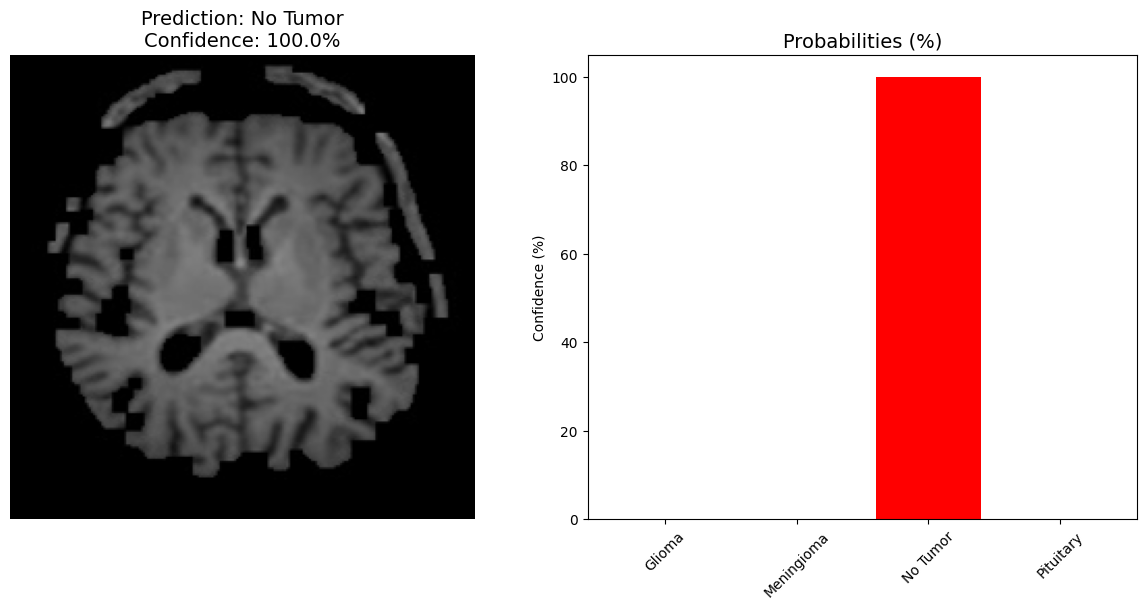


 RESULT: No Tumor (100.0% confidence)

 All Probabilities:
   Glioma: 0.00%
   Meningioma: 0.04%
   No Tumor: 99.96%
   Pituitary: 0.00%


In [11]:
quick_brain_tumor_test()


 Starting Quick Brain Tumor Test...
 Please upload an MRI brain scan image...


Saving Te-pi_0148.jpg to Te-pi_0148.jpg
 Loading model...


 Processing Te-pi_0148.jpg...
 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


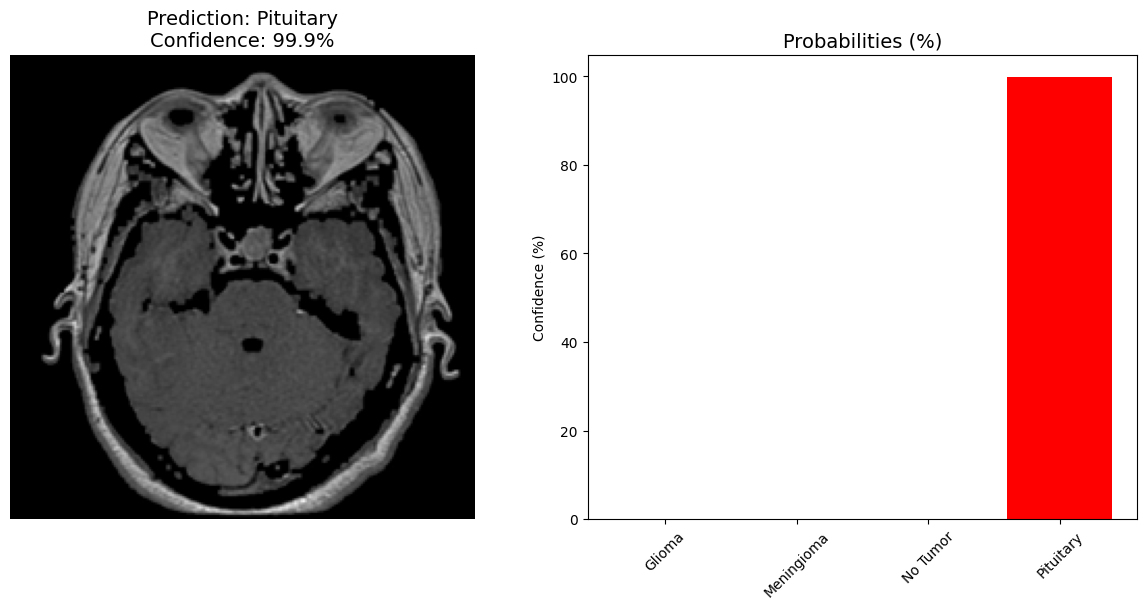


 RESULT: Pituitary (99.9% confidence)

 All Probabilities:
   Glioma: 0.00%
   Meningioma: 0.09%
   No Tumor: 0.00%
   Pituitary: 99.91%


In [12]:
quick_brain_tumor_test()

 Starting Quick Brain Tumor Test...
 Please upload an MRI brain scan image...


Saving Te-gl_0176.jpg to Te-gl_0176.jpg
 Loading model...


 Processing Te-gl_0176.jpg...
 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


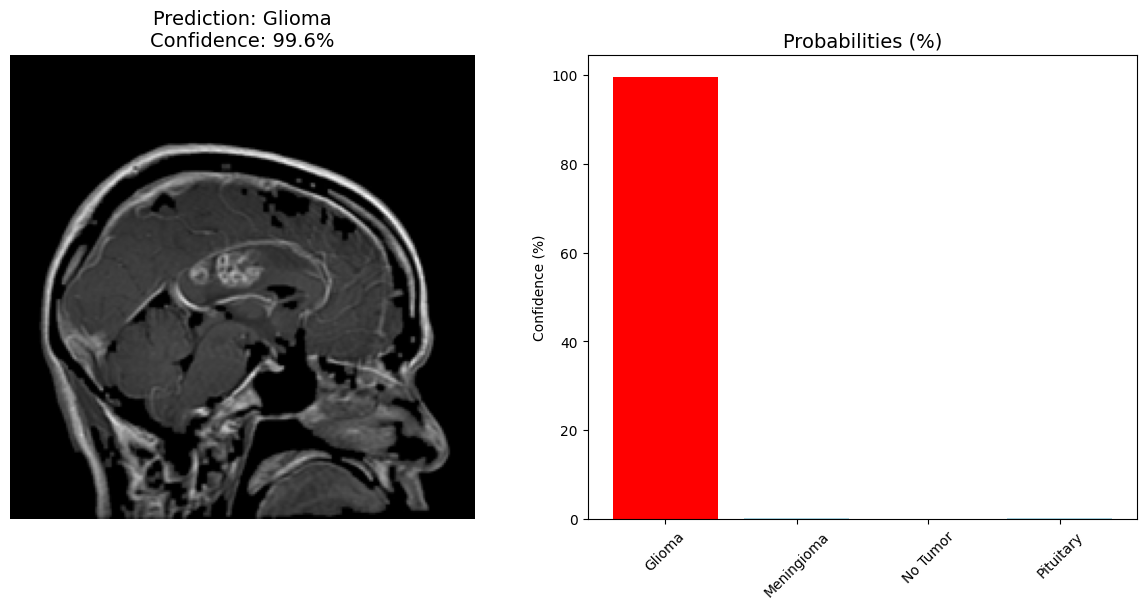


 RESULT: Glioma (99.6% confidence)

 All Probabilities:
   Glioma: 99.55%
   Meningioma: 0.24%
   No Tumor: 0.00%
   Pituitary: 0.20%


In [13]:
quick_brain_tumor_test()

 Starting Quick Brain Tumor Test...
 Please upload an MRI brain scan image...


Saving Te-me_0038.jpg to Te-me_0038.jpg
 Loading model...


 Processing Te-me_0038.jpg...
 Running prediction...


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


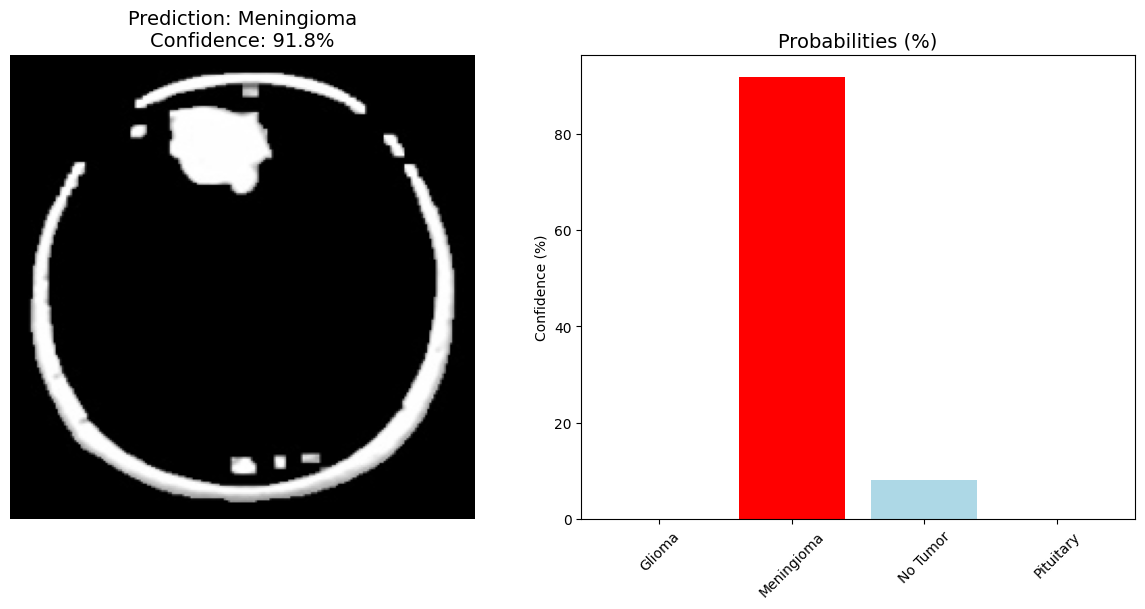


 RESULT: Meningioma (91.8% confidence)

 All Probabilities:
   Glioma: 0.00%
   Meningioma: 91.83%
   No Tumor: 8.11%
   Pituitary: 0.06%


In [14]:
quick_brain_tumor_test()